In [1]:
import sys
import os 
sys.path.append(os.path.abspath(os.path.join("", "..")))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn
from vanilla_vae import VanillaVAE
import wandb
import gc
import importlib
device = "cuda:0"

## Load VAE

In [2]:
# model_save_path = 'temp_vanilla_vae_latent512_beta0.01'

# from vanilla_vae import VanillaVAE

# latent_dim = 512
# beta = 0.01
# hidden_dims=[2048]

# vae_w2w =  VanillaVAE(input_dim=99648, latent_dim=latent_dim, hidden_dims=[2048], beta=beta, batch_norm=False)
# vae_w2w.load_state_dict(torch.load(os.path.join(model_save_path, "model.pt")))
# vae_w2w = vae_w2w.to(device)
# print(f"Model loaded from {model_save_path}")

import vae_w2w.vanilla_vae
importlib.reload(vae_w2w.vanilla_vae)
from vae_w2w.vanilla_vae import VanillaVAE

normalize_by_10 = True
batch_norm = False
latent_dim = 512
yining_hidden_dims = [2048, 1024]
yuchen_hidden_dims = [4096, 2048, 1024]

# yining_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yining_hidden_dims, batch_norm=False).to(device)
yuchen_vae = VanillaVAE(input_dim=99648, latent_dim=latent_dim,hidden_dims=yuchen_hidden_dims, batch_norm=False).to(device)

yining_model_path = "yining_vae.pt"
yuchen_model_path = "yuchen_vae.pt"

yuchen_state_dict = torch.load(yuchen_model_path, map_location=device)
yuchen_vae.load_state_dict(yuchen_state_dict)

# yining_state_dict = torch.load(yining_model_path, map_location=device)
# yining_vae.load_state_dict(yining_state_dict)

print(f"Model loaded from {yuchen_model_path}")

Model loaded from yuchen_vae.pt


## Run Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
import torch

def analyze_vae_latent_space(vae, weight_samples, device, n_samples=1000, n_random_samples=1000):
    """
    Comprehensive analysis of VAE latent space characteristics
    
    Args:
        vae: The VAE model
        weight_samples: Tensor of weight samples to analyze
        device: Device to run computations on
        n_samples: Number of samples to take from weights dataset
        n_random_samples: Number of random samples to generate
    """
    # Sample random rows from weight samples
    indices = torch.randperm(len(weight_samples))[:n_samples]
    weight_samples = weight_samples[indices]
    
    # Encode samples in batches to save memory
    batch_size = 100
    latent_samples = []
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = weight_samples[i:i+batch_size].to(device)
            encoded = vae.encode(batch)
            # Fix: encoded returns a tuple (mean, logvar), we want the mean
            latent_samples.append(encoded[0].cpu())  
            del batch
            torch.cuda.empty_cache()
    
    latent_samples = torch.cat(latent_samples, dim=0)
    
    # Generate random samples from standard normal for comparison
    random_z = torch.randn(n_random_samples, vae.latent_dim)
    
    # Convert to numpy for analysis
    latent_np = latent_samples.numpy()
    random_z_np = random_z.numpy()
    
    # Create figure for multiple plots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Distribution Analysis
    plt.subplot(3, 2, 1)
    for dim in range(min(5, vae.latent_dim)):
        plt.hist(latent_np[:, dim], bins=50, alpha=0.5, density=True, label=f'Dim {dim}')
    plt.title('Distribution of Top 5 Latent Dimensions')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    
    # 2. Latent Space Activity
    plt.subplot(3, 2, 2)
    dim_variance = np.var(latent_np, axis=0)
    plt.bar(range(len(dim_variance)), dim_variance)
    plt.axhline(y=0.1, color='r', linestyle='--', label='Activity Threshold')
    active_dims = np.sum(dim_variance > 0.1)
    plt.title(f'Dimension-wise Variance (Active dims: {active_dims}/{vae.latent_dim})')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Variance')
    plt.legend()
    
    # 3. PCA Analysis
    if vae.latent_dim > 2:
        plt.subplot(3, 2, 3)
        pca = PCA(n_components=2)
        latent_pca = pca.fit_transform(latent_np)
        random_pca = pca.transform(random_z_np)
        
        # Get the range of both axes to set equal scaling
        x_min = min(latent_pca[:, 0].min(), random_pca[:, 0].min())
        x_max = max(latent_pca[:, 0].max(), random_pca[:, 0].max())
        y_min = min(latent_pca[:, 1].min(), random_pca[:, 1].min())
        y_max = max(latent_pca[:, 1].max(), random_pca[:, 1].max())
        
        plt.scatter(random_pca[:, 0], random_pca[:, 1], alpha=0.5, label='Random', color='gray')
        plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.7, label='Encoded')
        plt.title(f'PCA Projection (Explained var: {pca.explained_variance_ratio_.sum():.2%})')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.legend()
        plt.axis('equal')  # This ensures equal aspect ratio
        # Set the limits to be equal in both dimensions
        max_range = max(x_max - x_min, y_max - y_min)
        x_center = (x_max + x_min) / 2
        y_center = (y_max + y_min) / 2
        plt.xlim(x_center - max_range/2, x_center + max_range/2)
        plt.ylim(y_center - max_range/2, y_center + max_range/2)
    
    # 4. Correlation Matrix
    plt.subplot(3, 2, 4)
    corr_matrix = np.corrcoef(latent_np.T)
    plt.imshow(corr_matrix, cmap='coolwarm', aspect='equal')
    plt.colorbar()
    plt.title('Latent Dimension Correlations')
    
    # 5. Reconstruction Quality
    plt.subplot(3, 2, 5)
    recon_error_np = []
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = weight_samples[i:i+batch_size].to(device)
            batch_latents = latent_samples[i:i+batch_size].to(device)
            recon = vae.decode(batch_latents)
            error = torch.nn.functional.mse_loss(recon, batch, reduction='none').mean(dim=1)
            recon_error_np.append(error.cpu().numpy())
            del batch, batch_latents, recon
            torch.cuda.empty_cache()
    
    recon_error_np = np.concatenate(recon_error_np)
    plt.hist(recon_error_np, bins=50, density=True)
    plt.title(f'Reconstruction Error (Mean: {recon_error_np.mean():.4f})')
    plt.xlabel('MSE')
    plt.ylabel('Count')
    
    # 6. Statistical Tests
    plt.subplot(3, 2, 6)
    normality_scores = []
    for dim in range(vae.latent_dim):
        _, p_value = stats.normaltest(latent_np[:, dim])
        normality_scores.append(-np.log10(p_value))
    
    plt.bar(range(len(normality_scores)), normality_scores)
    plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05 threshold')
    plt.title('Normality Test by Dimension')
    plt.xlabel('Latent Dimension')
    plt.ylabel('-log10(p-value)')
    plt.legend()
    
    plt.tight_layout()
    
    # Print summary statistics
    print("\n=== VAE Latent Space Analysis ===")
    print(f"Active dimensions (var > 0.1): {active_dims}/{vae.latent_dim}")
    print(f"Mean latent norm: {np.linalg.norm(latent_np.mean(axis=0)):.4f}")
    print(f"Average reconstruction error: {recon_error_np.mean():.4f}")
    print(f"Dimension correlation (mean abs): {np.abs(corr_matrix - np.eye(corr_matrix.shape[0])).mean():.4f}")
    
    if wandb.run is not None:
        wandb.log({
            "latent_analysis": wandb.Image(plt),
            "active_dimensions": active_dims,
            "mean_reconstruction_error": recon_error_np.mean(),
            "latent_norm": np.linalg.norm(latent_np.mean(axis=0))
        })
    
    return plt.gcf()


In [6]:
# Load weights dataset once
all_weights = torch.load('../weights_datasets/identities/all_weights.pt', map_location='cpu')


=== VAE Latent Space Analysis ===
Active dimensions (var > 0.1): 0/512
Mean latent norm: 0.4028
Average reconstruction error: 0.0215
Dimension correlation (mean abs): 0.2848


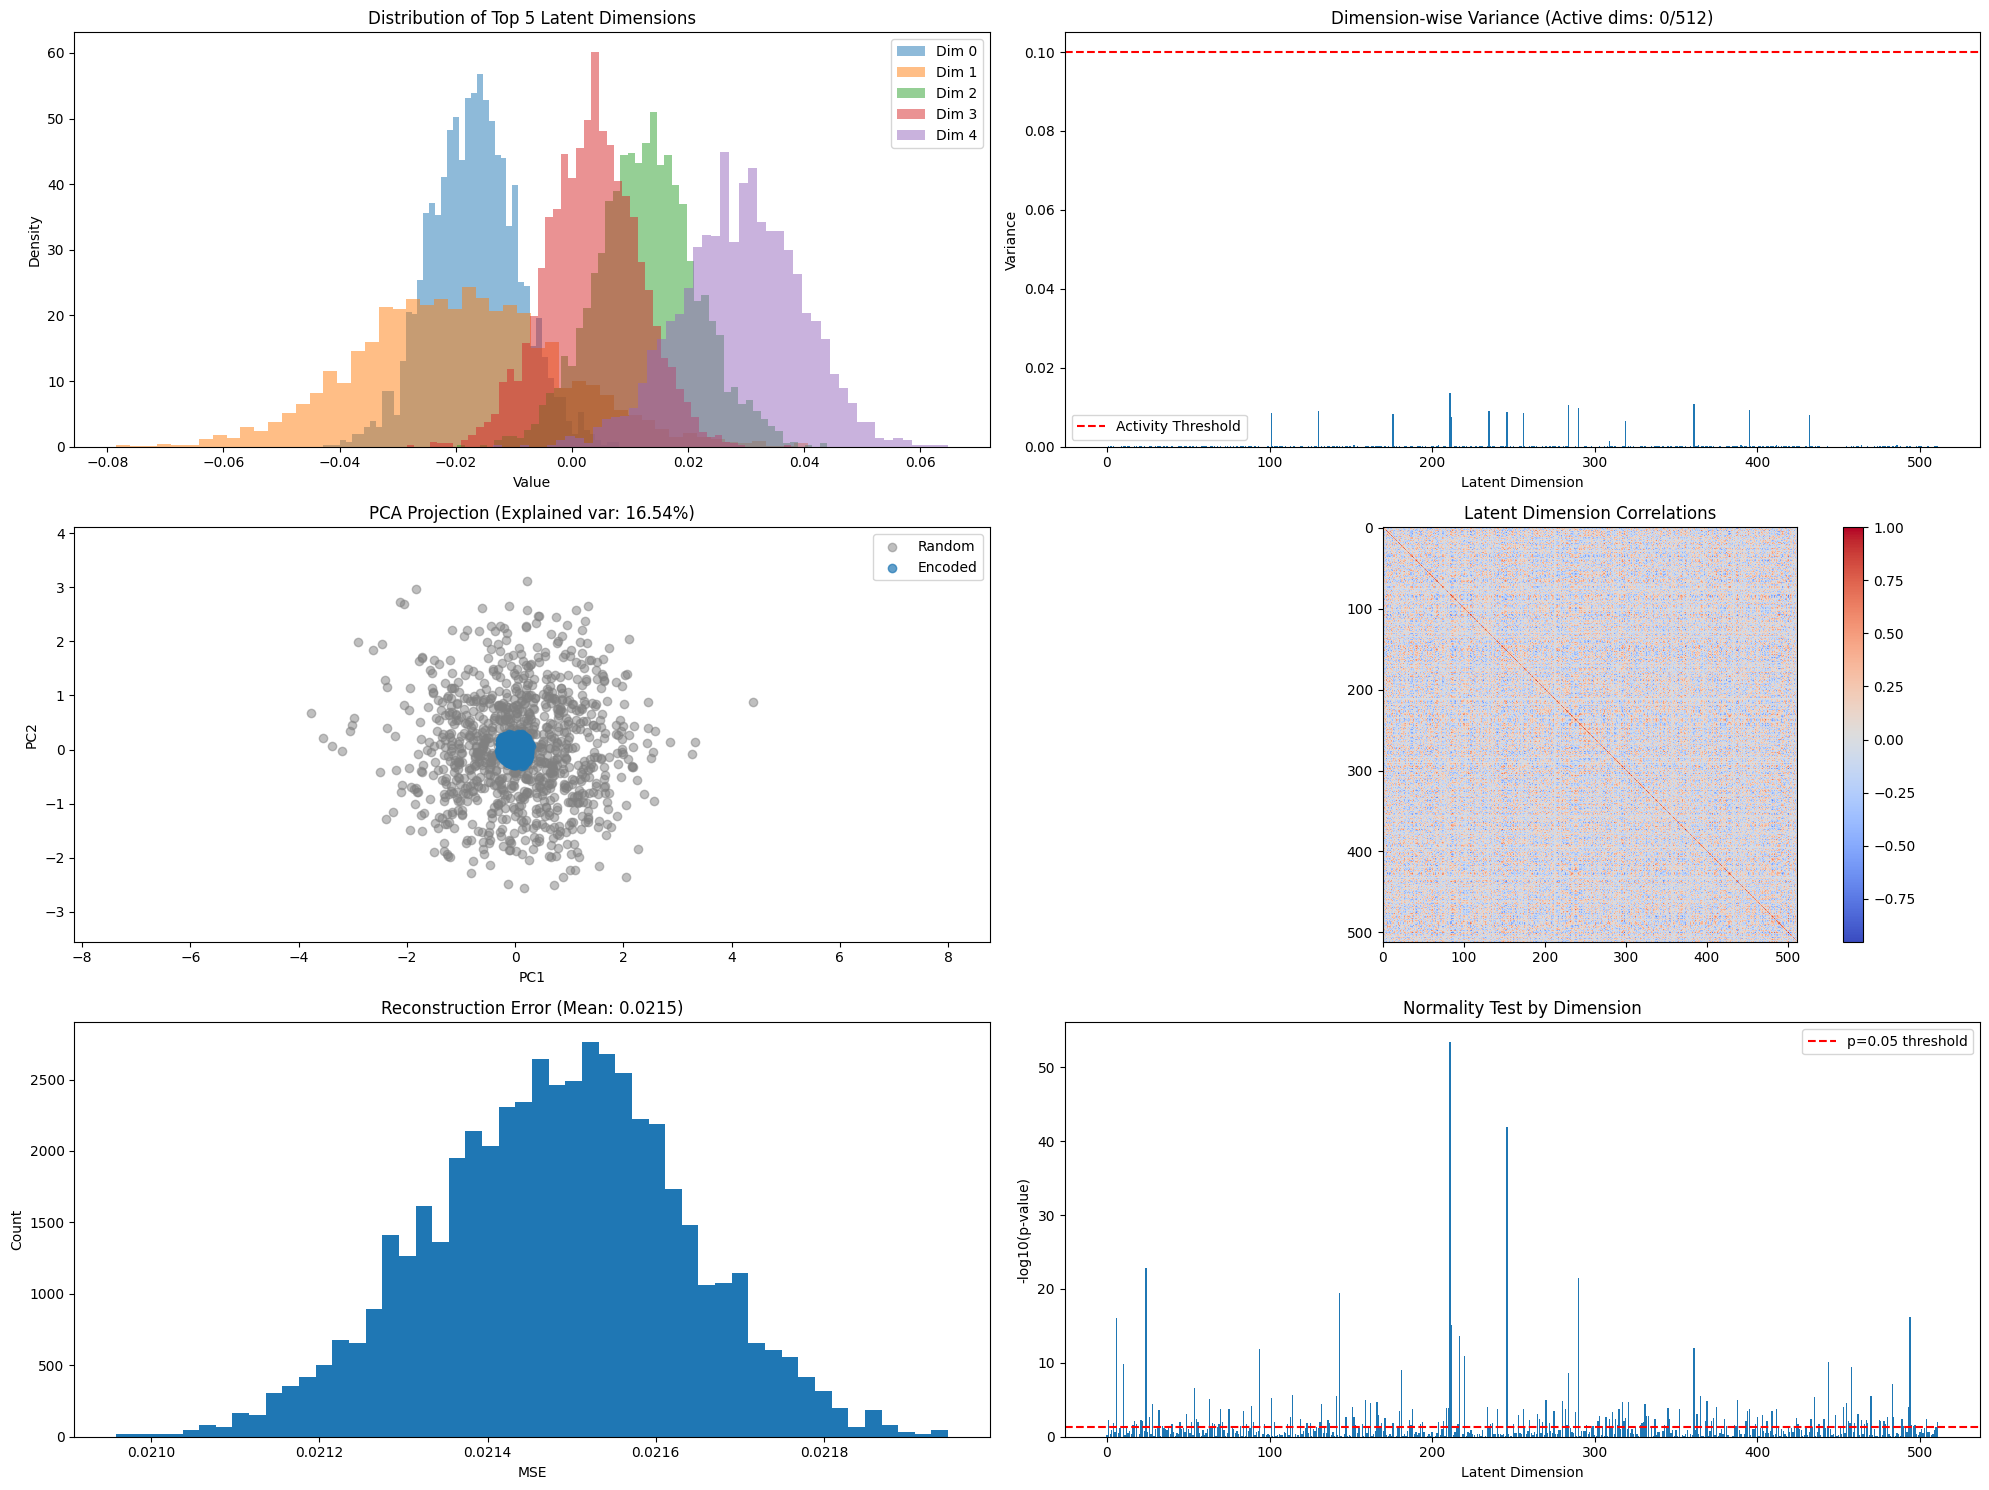

In [10]:
torch.cuda.empty_cache()
gc.collect()

# Analyze the latent space
analysis_plot = analyze_vae_latent_space(
    vae=yuchen_vae,
    weight_samples=all_weights,
    device=device,
    n_samples=3000
)
display(analysis_plot)
plt.close()

In [ ]:
#push